In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os

def cifar_load(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']
        Y = datadict[b'labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

# 2. Function to load the whole dataset
def load_cifar10(root_dir):
    xs = []
    ys = []
    # CIFAR-10 has 5 training batches
    for b in range(1, 6):
        f = os.path.join(root_dir, 'data_batch_%d' % (b, ))
        X, Y = cifar_load(f)
        xs.append(X)
        ys.append(Y)
    
    X_train = np.concatenate(xs)
    y_train = np.concatenate(ys)
    
    X_test, y_test = cifar_load(os.path.join(root_dir, 'test_batch'))
    
    return X_train, y_train, X_test, y_test

cifar_dir = 'cifar-10-python/cifar-10-batches-py' 

try:
    X_train_raw, y_train, X_test_raw, y_test = load_cifar10(cifar_dir)
    print(f"Loaded raw data.")
    print(f"Training data shape: {X_train_raw.shape}")
    print(f"Test data shape: {X_test_raw.shape}")
except FileNotFoundError:
    print(f"ERROR: Could not find the folder '{cifar_dir}'. Please extract the dataset correctly.")

# 3. Flatten the images
# Current shape: (50000, 32, 32, 3) -> Flatten to (50000, 3072)
X_train = np.reshape(X_train_raw, (X_train_raw.shape[0], -1))
X_test = np.reshape(X_test_raw, (X_test_raw.shape[0], -1))

print(f"Flattened Training shape: {X_train.shape}")
print(f"Flattened Test shape: {X_test.shape}")

D:\Temp\ipykernel_26476\2581057102.py:9: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  datadict = pickle.load(f, encoding='bytes')


Loaded raw data.
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Flattened Training shape: (50000, 3072)
Flattened Test shape: (10000, 3072)


Subsampled Train Shape: (5000, 3072)
Subsampled Test Shape: (500, 3072)


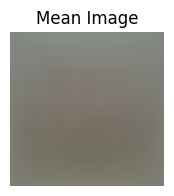

In [3]:
# 1. Subsample the data for Experimentation
# We use 5000 training points and 500 test points
num_training = 5000
num_test = 500

mask_train = range(num_training)
mask_test = range(num_test)

X_train_sub = X_train[mask_train]
y_train_sub = y_train[mask_train]
X_test_sub = X_test[mask_test]
y_test_sub = y_test[mask_test]

print(f"Subsampled Train Shape: {X_train_sub.shape}")
print(f"Subsampled Test Shape: {X_test_sub.shape}")

# 2. Normalize the data (Subtract Mean)
# Just subtracting the mean image is standard for image classification
mean_image = np.mean(X_train_sub, axis=0)
X_train_sub -= mean_image
X_test_sub -= mean_image

# (Optional visualization of mean image)
plt.figure(figsize=(2,2))
plt.imshow(mean_image.reshape(32,32,3).astype('uint8'))
plt.title("Mean Image")
plt.axis('off')
plt.show()

In [4]:
from collections import Counter

class KNN:
    def __init__(self, k=3, metric='euclidean', p=3):
        self.k= k
        self.metric = metric
        self.p = p
        self.x_train = None
        self.y_train = None

    def fit(self,x, y):
        self.x_train = np.array(x)
        self.y_train = np.array(y)

    def predict(self, x_test):
        x_test = np.array(x_test)
        prediction = []
        # calc dist between all train and all test points
        if self.metric == 'euclidean':
            dists = self._calc_euclidean(x_test)
        elif self.metric == 'manhattan':
            dists = self._calc_manhattan(x_test)
        elif self.metric == 'minkowski':
            dists = self._calc_minkowski(x_test)
        elif self.metric == 'cosine':
            dists = self._calc_cosine(x_test)
        elif self.metric == 'hamming':
            dists = self._calc_hamming(x_test)
        else:
            raise ValueError("Unknown metric")

    
        for i in range(len(x_test)):
            # get k nearest labels
            k_indices = np.argsort(dists[i])[:self.k]
            # get labels
            k_labels = [self.y_train[j] for j in k_indices]
            # majority
            common = Counter(k_labels).most_common(1)
            prediction.append(common[0][0])
        return np.array(prediction)
    
    def _calc_euclidean(self, x_test):
        test_sq = np.sum(x_test**2, axis=1).reshape(-1, 1)
        train_sq = np.sum(self.x_train**2, axis=1).reshape(1, -1)
        dot_prod = np.dot(x_test, self.x_train.T)

        return np.sqrt(test_sq + train_sq - 2*dot_prod)

    def _calc_manhattan(self, x_test):
        dists = np.zeros((x_test.shape[0], self.x_train.shape[0]))
        for i in range(x_test.shape[0]):
            dists[i, :] = np.sum(np.abs(self.x_train - x_test[i, :]), axis=1)
        return dists

    def _calc_minkowski(self, x_test):
        dists = np.zeros((x_test.shape[0], self.x_train.shape[0]))
        for i in range(x_test.shape[0]):
            dists[i, :] = np.sum(np.abs(self.x_train - x_test[i, :])**self.p, axis=1)**(1/self.p)
        return dists
    
    def _calc_cosine(self, x_test):
        x_test_norm = x_test / np.linalg.norm(x_test, axis=1, keepdims=True)
        x_train_norm = self.x_train / np.linalg.norm(self.x_train, axis=1, keepdims=True)
        cosine_sim = np.dot(x_test_norm, x_train_norm.T)
        return 1 - cosine_sim  # convert similarity to distance
    
    def _calc_hamming(self, x_test):
        dists = np.zeros((x_test.shape[0], self.x_train.shape[0]))
        for i in range(x_test.shape[0]):
            dists[i, :] = np.sum(self.x_train != x_test[i, :], axis=1)
        return dists
    
    print("KNN class defined.")
    

KNN class defined.


Starting CIFAR-10 Experiments...
Running euclidean...
   k=3: 0.2800
   k=4: 0.2840
   k=9: 0.2900
   k=20: 0.2660
   k=47: 0.2520
Running manhattan...
   k=3: 0.2980
   k=4: 0.3080
   k=9: 0.3020
   k=20: 0.2880
   k=47: 0.2720
Running minkowski...
   k=3: 0.2280
   k=4: 0.2420
   k=9: 0.2560
   k=20: 0.2520
   k=47: 0.2300
Running cosine...
   k=3: 0.3200
   k=4: 0.3320
   k=9: 0.3480
   k=20: 0.3500
   k=47: 0.3120
Running hamming...
   k=3: 0.1980
   k=4: 0.2180
   k=9: 0.2380
   k=20: 0.2540
   k=47: 0.2500
Done.


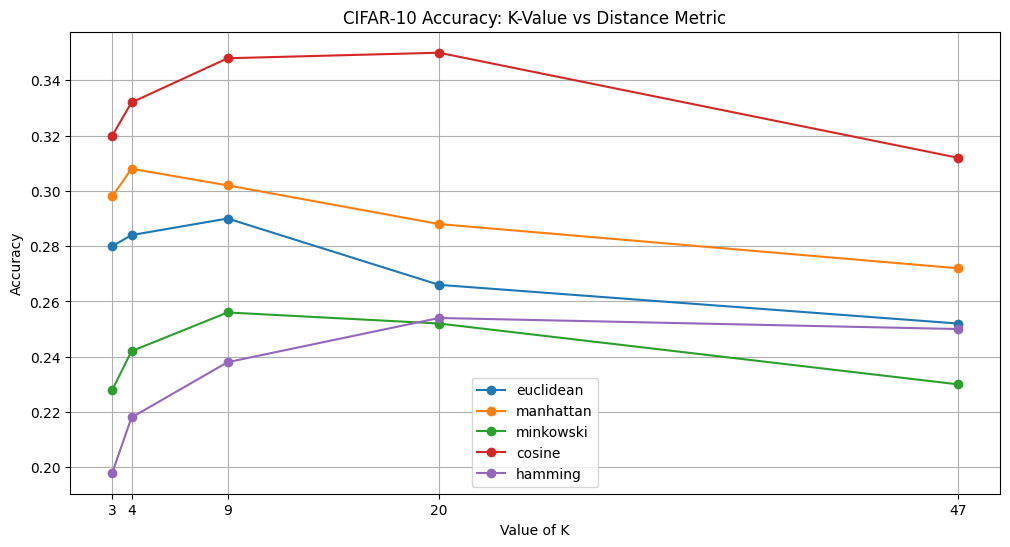

In [5]:
# Setup for CIFAR-10 Experiments

def get_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)
k_values_cifar = [3, 4, 9, 20, 47]
metrics_cifar = ['euclidean', 'manhattan', 'minkowski', 'cosine', 'hamming']
results_cifar = {}

print("Starting CIFAR-10 Experiments...")

for metric in metrics_cifar:
    print(f"Running {metric}...")
    accuracies = []
    for k in k_values_cifar:
        # Initialize
        clf = KNN(k=k, metric=metric)
        clf.fit(X_train_sub, y_train_sub)
        
        # Predict
        preds = clf.predict(X_test_sub)
        
        # Accuracy
        acc = get_accuracy(y_test_sub, preds)
        accuracies.append(acc)
        print(f"   k={k}: {acc:.4f}")
        
    results_cifar[metric] = accuracies

print("Done.")

# Plotting CIFAR Results
plt.figure(figsize=(12, 6))
for metric in results_cifar:
    plt.plot(k_values_cifar, results_cifar[metric], marker='o', label=metric)

plt.title('CIFAR-10 Accuracy: K-Value vs Distance Metric')
plt.xlabel('Value of K')
plt.ylabel('Accuracy')
plt.xticks(k_values_cifar)
plt.legend()
plt.grid(True)
plt.show()